In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../")
from utils import visualize_generator_model

In [2]:
# fix random seeds
rng_seed = 3  # negative posterior with: 3, 5, 6, 8, 9
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

## Load Xopt Run

In [3]:
def get_model_predictions(input_dict, generator = None):
    output_dict = {}
    for output_name in generator.vocs.output_names:
        if generator is not None and generator.model is not None:
            gp = generator.model.models[generator.vocs.output_names.index(output_name)]
            x = torch.tensor([input_dict[k] for k in generator.vocs.variable_names], dtype=torch.double).unsqueeze(0)
            with torch.no_grad():
                _x = gp.input_transform.transform(x)
                _x = gp.mean_module(_x)
                prior_mean = gp.outcome_transform.untransform(_x)[0].item()
                posterior = gp.posterior(x)
                posterior_mean = posterior.mean.item()
                posterior_sd = torch.sqrt(posterior.mvn.variance).item()
        else:
            prior_mean, posterior_mean, posterior_sd = np.nan, np.nan, np.nan
    
        output_dict[output_name + "_prior_mean"] = prior_mean
        output_dict[output_name + "_posterior_mean"] = posterior_mean
        output_dict[output_name + "_posterior_sd"] = posterior_sd
    return output_dict

In [4]:
def eval_beamsize(input_dict):
    pass

In [5]:
data_dir = "../../data/20231002_LCLS_Injector/"
filename = "nn_optimization_9d_5_prior_adjusted.yml"

with open(data_dir + filename) as f:
    X = Xopt.from_yaml(f)
X.data.index = X.data.index.values.astype(int)
X.data = X.data.sort_index()

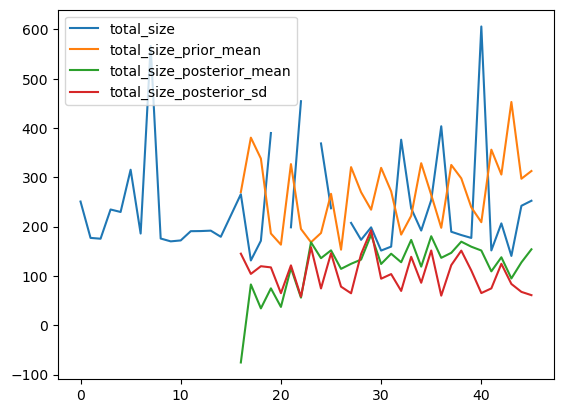

In [6]:
X.data[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

## Load NN Prior Model

In [7]:
model_path = "../lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=X.vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y) + 100.0

objective_model = ObjectiveModel(lume_module)

## Negative Posterior Values

In [8]:
idx = 15
input_dict = X.data.iloc[idx][X.vocs.variable_names].to_dict()
input_dict

{'QUAD:IN20:121:BCTRL': -0.0080117277,
 'QUAD:IN20:122:BCTRL': -0.0122183569,
 'QUAD:IN20:361:BCTRL': -3.4093373716,
 'QUAD:IN20:371:BCTRL': 2.5430055688,
 'QUAD:IN20:425:BCTRL': -1.7484424431,
 'QUAD:IN20:441:BCTRL': -0.6603721661,
 'QUAD:IN20:511:BCTRL': 3.8420324658,
 'QUAD:IN20:525:BCTRL': -2.3241027943,
 'SOLN:IN20:121:BCTRL': 0.4733820162}

In [9]:
input_tensor = torch.tensor([v for k, v in input_dict.items()]).unsqueeze(0)
output_tensor = objective_model(input_tensor)
output_tensor.item()

270.0681907217745

In [10]:
# create Xopt object from scratch
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={X.vocs.objective_names[0]: objective_model},
)
generator = ExpectedImprovementGenerator(
    vocs=X.vocs,
    model_constructor=model_constructor,
    
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": generator})
X_new = Xopt(generator=generator, evaluator=evaluator, vocs=X.vocs)
X_new.evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": X_new.generator})

In [11]:
# add data and train model
X_new.add_data(X.data.iloc[:idx])
_ = X_new.generator.train_model(X_new.data)

In [12]:
print(X.data.iloc[idx][X.vocs.objective_names[0] + "_posterior_mean"])
print(get_model_predictions(input_dict, X_new.generator)[X.vocs.objective_names[0] + "_posterior_mean"])

-75.4443369345
-83.62324946725917


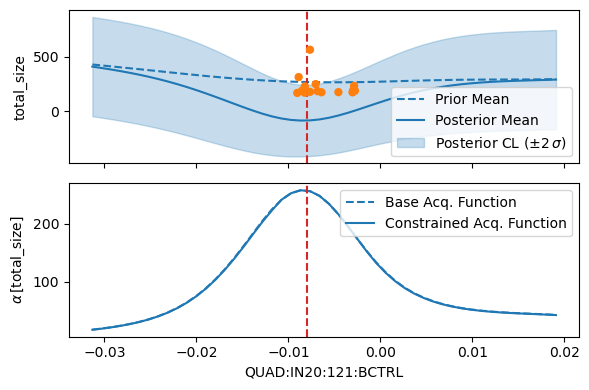

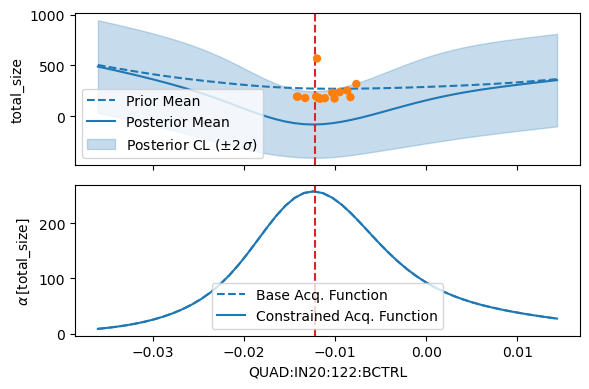

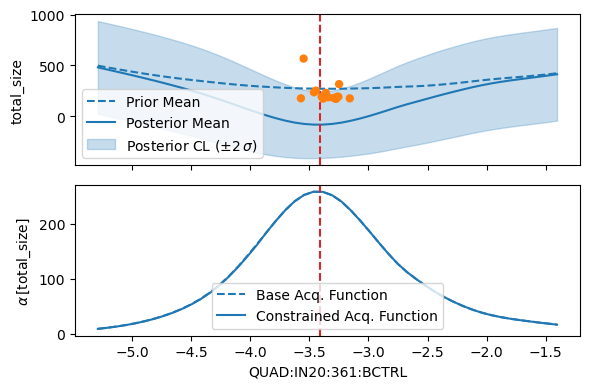

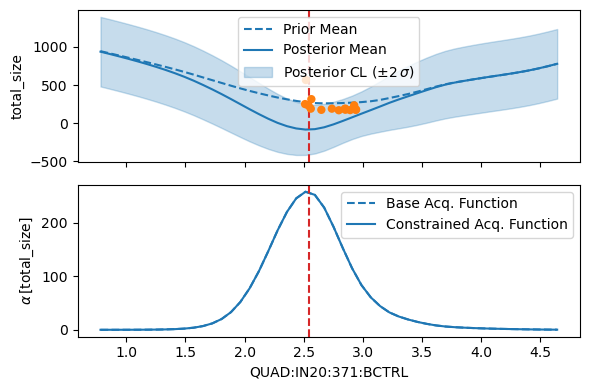

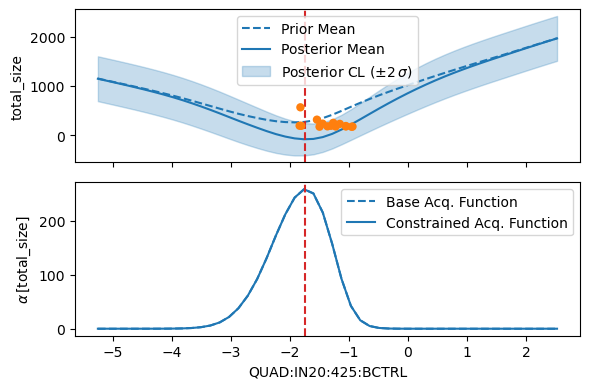

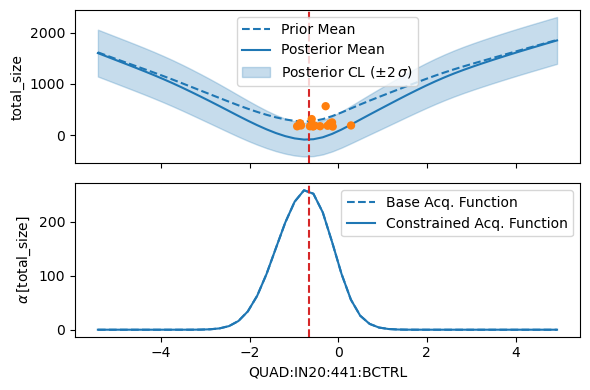

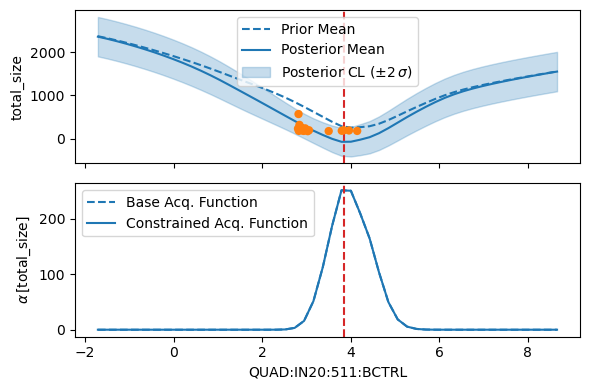

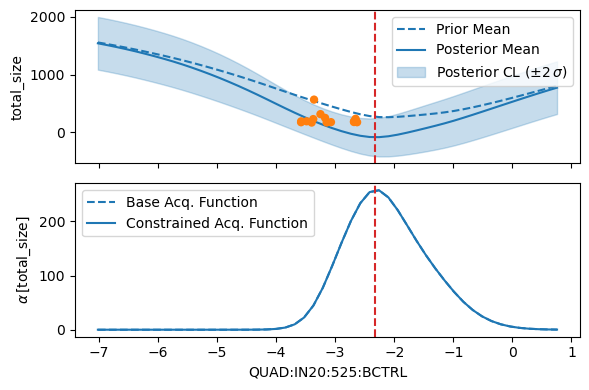

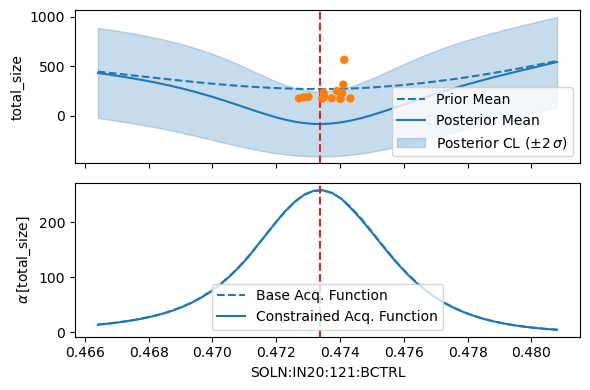

In [13]:
for name in X_new.vocs.variable_names:
    fig, ax = visualize_generator_model(
        generator=X_new.generator,
        output_names=[X_new.vocs.output_names[0]],
        variable_names=[name],
        reference_point=input_dict,
        show_prior_mean=True,
        scale_variable_range=1.0,
    )
    for ax_i in ax.flatten():
        ax_i.axvline(x=input_dict[name], linestyle="--", c="C3")
    fig.tight_layout()

In [14]:
var_names, ls = [], []
gp = X_new.generator.model.models[X_new.generator.vocs.output_names.index(X.vocs.objective_names[0])]
for i, name in enumerate(X_new.vocs.variable_names):
    var_names.append(name)
    ls.append(gp.covar_module.base_kernel.lengthscale[0, i].item())
lengthscales = pd.DataFrame({"Lengthscale": ls}, index=var_names)
lengthscales

,Lengthscale
QUAD:IN20:121:BCTRL,0.487959
QUAD:IN20:122:BCTRL,0.470308
QUAD:IN20:361:BCTRL,0.494164
QUAD:IN20:371:BCTRL,0.382684
QUAD:IN20:425:BCTRL,0.388521
QUAD:IN20:441:BCTRL,0.484916
QUAD:IN20:511:BCTRL,0.417553
QUAD:IN20:525:BCTRL,0.539049
SOLN:IN20:121:BCTRL,0.477744


In [15]:
gp.likelihood.noise_covar.noise.item()

0.9196212444046961

In [16]:
from gpytorch import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll

In [17]:
model = X_new.generator.model.models[0]
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_mll = fit_gpytorch_mll(mll)

In [18]:
fit_mll.training

False

In [19]:
print(get_model_predictions(input_dict, X_new.generator)[X.vocs.objective_names[0] + "_posterior_mean"])

-84.06539492622201


In [20]:
var_names, ls = [], []
gp = X_new.generator.model.models[X_new.generator.vocs.output_names.index(X.vocs.objective_names[0])]
for i, name in enumerate(X_new.vocs.variable_names):
    var_names.append(name)
    ls.append(gp.covar_module.base_kernel.lengthscale[0, i].item())
lengthscales = pd.DataFrame({"Lengthscale": ls}, index=var_names)
lengthscales

,Lengthscale
QUAD:IN20:121:BCTRL,0.487623
QUAD:IN20:122:BCTRL,0.470817
QUAD:IN20:361:BCTRL,0.493975
QUAD:IN20:371:BCTRL,0.381726
QUAD:IN20:425:BCTRL,0.388948
QUAD:IN20:441:BCTRL,0.484498
QUAD:IN20:511:BCTRL,0.417779
QUAD:IN20:525:BCTRL,0.538469
SOLN:IN20:121:BCTRL,0.477529


In [21]:
gp.likelihood.noise_covar.noise.item()

0.9148171224969018